# Testing re-clustering after napari

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def show_spots(images) :

    if isinstance(images, np.ndarray) :
        images = [images]
    if len(images) > 1 :
        fig, axes = plt.subplots(1, len(images))
    elif len(images) == 1 :
        fig = plt.figure()
        axes = [fig.gca()]

    for ax, im in zip(axes, images) :
        ax.imshow(im)
    plt.show()

## Initializing spots

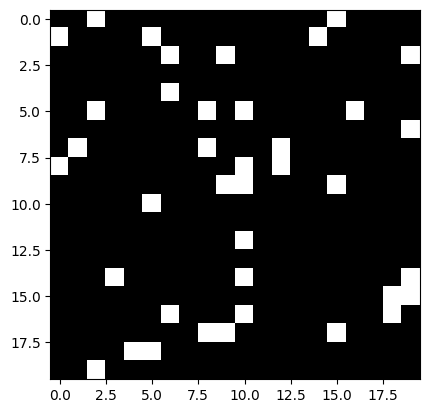

In [2]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

SEED = 1
random_generator = np.random.default_rng(seed=SEED)

SHAPE = (20,20)
SPOTS_NUM = 40
CLUSTER_RADIUS = 2
MIN_SPOT = 4

image = np.zeros(SHAPE + (3,), dtype=np.uint8)
spots = random_generator.integers([0]*len(SHAPE),SHAPE, (SPOTS_NUM,len(SHAPE)))

spot_image = image.copy()
spot_image[tuple(list(zip(*spots)))] = 255
show_spots([spot_image])

## Computing clusters

In [3]:
dbscan_model = DBSCAN(CLUSTER_RADIUS, min_samples=MIN_SPOT)
dbscan_model.fit(spots)

spots_labels = dbscan_model.labels_.reshape(len(spots),1)

spots_first_clustering = np.concatenate([spots, spots_labels], axis=1)
cluster_number = len(np.unique(spots_first_clustering[:,-1])) - 1
print("{0} clusters found.".format(cluster_number))

2 clusters found.


### Visualisation with clustered spots in red

((9, 15, 16, 9, 14, 8, 8, 15), (10, 19, 18, 9, 19, 10, 12, 18))
[[255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]]


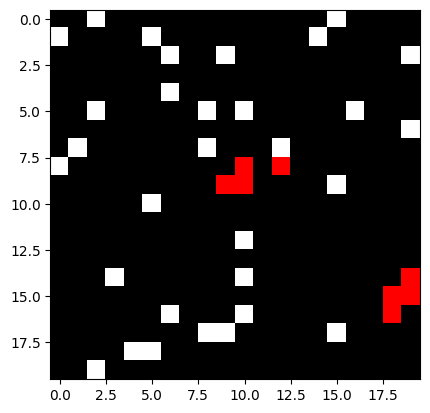

In [4]:
clustered_spots_index = tuple(list(zip(*spots_first_clustering[:,:-1][spots_first_clustering[:,-1] != -1])))

spot_image[clustered_spots_index] = [255,0,0]

print(clustered_spots_index)
print(spot_image[clustered_spots_index])
show_spots(spot_image)

## Adding a new cluster

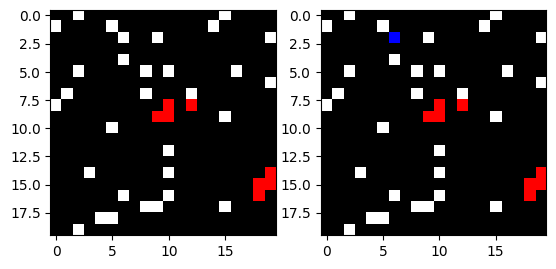

In [5]:
NEW_CLUSTER_COORDINATES = (2,6) # Shown in blue; in software this is picked by user during Napari correction.
corrected_image = spot_image.copy()
corrected_image[NEW_CLUSTER_COORDINATES] = [0,0,255]
show_spots([spot_image, corrected_image])

### Using sklearn.NearestNeighbours to find spots in radius of new cluster

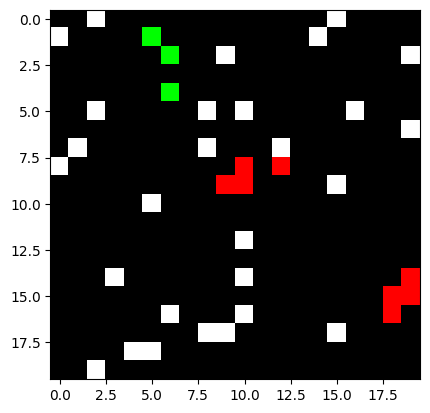

In [6]:
NearestNeighbors_model = NearestNeighbors(radius=CLUSTER_RADIUS)
NearestNeighbors_model.fit(spots)
query = NearestNeighbors_model.radius_neighbors(np.array([NEW_CLUSTER_COORDINATES], dtype=int), return_distance=False)
neighbours = spots[query[0]]
indexer = tuple(list(
    zip(*neighbours)
))
corrected_image[indexer] = [0,255,0]
show_spots(corrected_image)

## Changing weights so that 2nd round of DBSCAN add the new cluster and only that one.

In [7]:
weights = np.ones(len(spots), dtype=float) 
number_in_radius = len(neighbours)
weights[query[0]] = MIN_SPOT/number_in_radius # >1
print(weights)

[1.         1.         1.         1.         1.33333333 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.33333333 1.         1.         1.
 1.         1.         1.         1.33333333 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


In [8]:
second_dbscan = DBSCAN(CLUSTER_RADIUS, min_samples=MIN_SPOT)
second_dbscan.fit(spots, sample_weight= weights)
spots_labels = second_dbscan.labels_.reshape(len(spots),1)
spots_second_clustering = np.concatenate([spots, spots_labels], axis=1)


### Visualisation with clustered spots in red

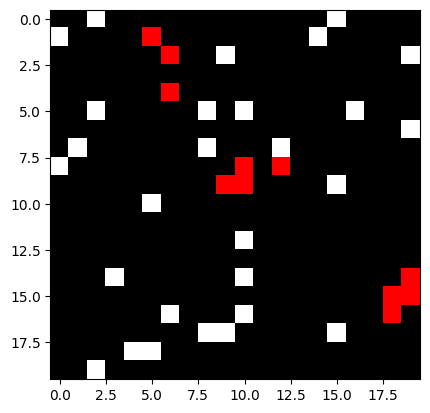

In [9]:
clustered_spots_index = tuple(list(zip(*spots_second_clustering[:,:-1][spots_second_clustering[:,-1] != -1])))
corrected_image[clustered_spots_index] = [255,0,0]
show_spots(corrected_image)

from bigfish.detection import cluster_detection

# Points layer feature and default features

In [10]:
import napari
import numpy as np

## Init spots

In [11]:
SEED = 1
random_generator = np.random.default_rng(seed=SEED)

SHAPE = (100,100)
SPOTS_NUM = 600
CLUSTER_RADIUS = 2
MIN_SPOT = 4

image = np.zeros(SHAPE + (3,), dtype=np.uint8)
spots = random_generator.integers([0]*len(SHAPE),SHAPE, (SPOTS_NUM,len(SHAPE)))
spots_id = np.arange(len(spots))


## Init Viewer

In [12]:
Viewer = napari.Viewer()
point_layer = Viewer.add_points(
    spots,
    size= 2,
    features={"id" : spots_id},
    feature_defaults={"id" : -1}
)
napari.run()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x78c1402a7ee0>>
Traceback (most recent call last):
  File "/home/floric/miniconda3/envs/dev/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
new_spots_ids = point_layer.features.to_numpy()
new_spots_coord = np.round(point_layer.data).astype(int)
new_spots = np.concatenate([new_spots_coord, new_spots_ids], axis=1)
new_spots   

array([[47, 51,  0],
       [75, 95,  1],
       [ 3, 14,  2],
       ...,
       [27, 62, -1],
       [28, 64, -1],
       [30, 69, -1]])

# Testing napari event

In [2]:
import os
os.environ["QT_QPA_PLATFORM"] = "xcb"
import numpy as np
import napari

In [ ]:
import napari.layers


viewer = napari.Viewer(title= "Tesing mouse events")

shape = (500,500)

#Adding 2 layers of spots
generator = np.random.default_rng(seed=0)
spots1 = generator.integers(
    low= (0,0),
    high= shape,
    size= (1000,2)
)

spots2 = generator.integers(
    low= (0,0),
    high= shape,
    size= (10,2)
)

cluster_id = generator.integers(
    low=-1,
    high=len(spots2),
    size=len(spots1)
)


layer1 = viewer.add_points(spots1, face_color= 'white', features={'cluster_id' : cluster_id})
layer2 : napari.layers.Points = viewer.add_points(spots2, face_color='red', features={'cluster_id' : np.arange(len(spots2))})

def on_selection_change(event):
    print("Changed!")
    selected_indices = layer2.selected_data
    if len(selected_indices) == 1 :
        idx = list(selected_indices)[0]
        selected_cluster = layer2.features.at[idx,'cluster_id']

        print("selected cluster : ", selected_cluster)

        belonging_spots_index = layer1.features.loc[layer1.features['cluster_id'] == selected_cluster].index.to_numpy()
        layer1.face_color[belonging_spots_index] = [0,1,0,1]
        layer1.refresh()


    else :
        pass
layer2.selected_data.events. .connect(on_selection_change)

viewer.show(block=True)
try :
    viewer.close()
except Exception :
    pass

selected cluster :  3
selected cluster :  4
selected cluster :  3
selected cluster :  1
selected cluster :  6
